In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *

### Load H36M 

In [3]:
h36m_3d_world, h36m_cam_param = load_h36m()

subject = 'S1'
action = 'Walking'
action_list = h36m_3d_world._data[subject].keys()
pose_3d_list = h36m_3d_world._data[subject][action]['positions'] # 3d skeleton sequence wrt world CS
cam_info = h36m_3d_world._data[subject][action]['cameras']
cam_param = get_cam_param(cam_info, subject, h36m_cam_param)

==> Loading 3D data wrt World CS...


### Middle Rotation Axis (MRA) 

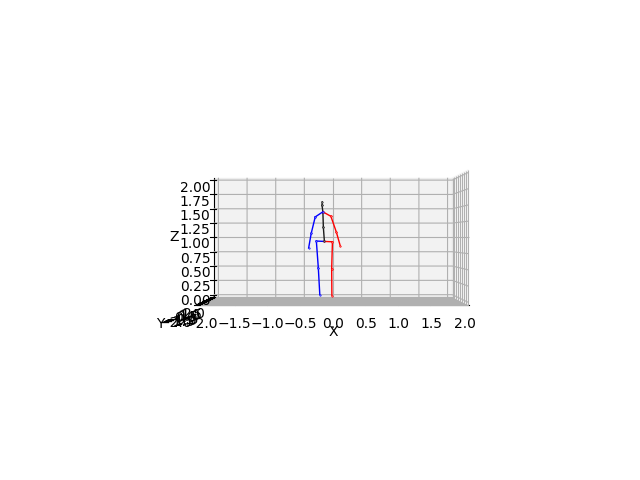

In [4]:
pose_3d = pose_3d_list[0]

%matplotlib widget
fig = plt.figure(0)
ax = axes_3d(fig, zlim=(0, 2), view=(0, -90))
draw_3d_pose(ax, pose_3d)
plt.show()

In [5]:
joint_r_shoulder = pose_3d[get_h36m_keypoint_index('r_shoulder')]
joint_r_elbow = pose_3d[get_h36m_keypoint_index('r_elbow')]
joint_r_wrist = pose_3d[get_h36m_keypoint_index('r_wrist')]
joint_l_shoulder = pose_3d[get_h36m_keypoint_index('l_shoulder')]

In [6]:
v_r_shoulder_to_elbow = joint_r_elbow - joint_r_shoulder
v_r_elbow_to_wrist = joint_r_wrist - joint_r_elbow
v_r_shoulder_to_wrist = joint_r_wrist - joint_r_shoulder 
v_r_shoulder_to_joint_l_shoulder = joint_l_shoulder - joint_r_shoulder
len_r_upper_arm = np.linalg.norm(v_r_shoulder_to_elbow)
len_r_lower_arm = np.linalg.norm(v_r_elbow_to_wrist)
L1, L2 = len_r_upper_arm, len_r_lower_arm
L3 = np.linalg.norm(v_r_shoulder_to_wrist)

In [7]:
z_axis_local = np.array([0, 0, 1])
y_axis_local = v_r_shoulder_to_joint_l_shoulder / np.linalg.norm(v_r_shoulder_to_joint_l_shoulder)
x_axis_local = np.cross(y_axis_local, z_axis_local)
R_local = np.array([x_axis_local, y_axis_local, z_axis_local]).T
local_frame = generate_vis_frame(joint_r_shoulder, R_local)

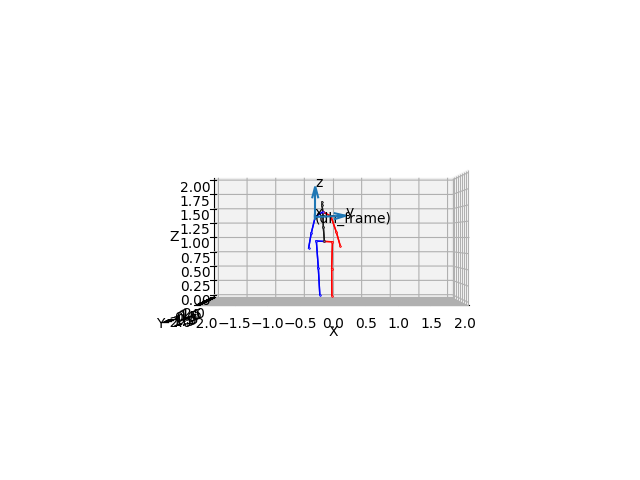

In [8]:
draw_3d_pose(ax, pose_3d)
local_frame.draw3d()
plt.show()

In [9]:
elbow_flexion = (L3**2 - L1**2 - L2**2) / (2*L1*L2)
elbow_flexion = np.arccos(elbow_flexion)
elbow_flexion, math.degrees(elbow_flexion)  

(0.2675642805617315, 15.330304024641466)

In [48]:
d = R_local @ v_r_shoulder_to_wrist
d_prime = joint_r_shoulder + np.array([0, 0, -L1]) + R_local @ np.array([np.sin(np.pi-elbow_flexion)*L2, 0, np.cos(np.pi-elbow_flexion)*L2])
d_prime

array([-0.29298808,  0.04884273,  0.81590499])

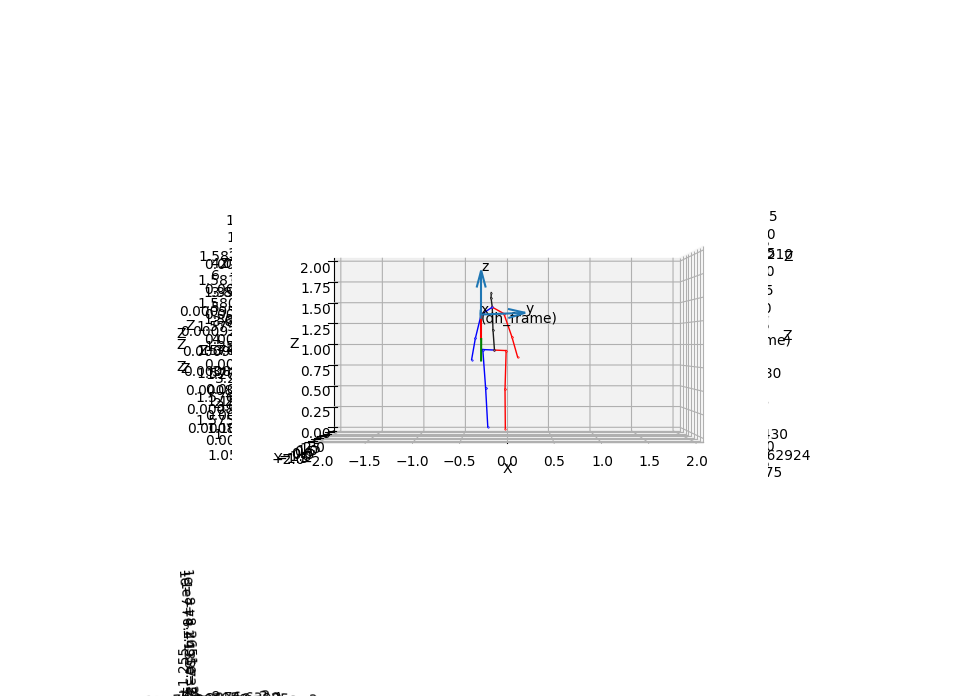

In [49]:
point1 = joint_r_shoulder
point2 = joint_r_shoulder + np.array([0, 0, -L1])
point3 = d_prime

fig = plt.figure(1)
ax = axes_3d(fig, zlim=(0, 2), view=(0, -90))
draw_3d_pose(ax, pose_3d)
ax.plot([point1[0], point2[0]], [point1[1], point2[1]], [point1[2], point2[2]], 'r')
ax.plot([point2[0], point3[0]], [point2[1], point3[1]], [point2[2], point3[2]], 'g')
local_frame.draw3d()
plt.show()

In [50]:
shoulder_flexion = math.atan((joint_r_wrist[1] - joint_r_shoulder[1])/(joint_r_wrist[0] - joint_r_shoulder[0]))
shoulder_flexion, math.degrees(shoulder_flexion)

(0.48132500056262245, 27.57789110637024)

In [51]:
np.dot(d, d_prime), np.dot(d, d), np.dot(d, d_prime)/np.dot(d, d)

(-0.39763017461707056, 0.27879140310136935, -1.4262641178806044)

In [54]:
shoulder_abduction = math.acos(np.dot(d, d_prime)/np.dot(d, d))

ValueError: math domain error